In [1]:
!git clone https://github.com/IMvision12/SegFormer-tf

Cloning into 'SegFormer-tf'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 146 (delta 65), reused 70 (delta 26), pack-reused 0
Receiving objects: 100% (146/146), 272.88 KiB | 10.92 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
cd SegFormer-tf

/kaggle/working/SegFormer-tf


In [3]:
import numpy as np 
import pandas as pd
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from models import SegFormer_B0

In [4]:
EPOCHS=20
BATCH_SIZE=32
HEIGHT=256
WIDTH=256
CHANNELS=3
N_CLASSES=13
AUTO = tf.data.AUTOTUNE

In [5]:
def loadImage(path):
    img = Image.open(path)
    img = np.array(img)
    
    image = img[:,:256]
    image = image / 255.0
    mask = img[:,256:]
    
    return image, mask

def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [6]:
train_folder = "/kaggle/input/cityscapes-image-pairs/cityscapes_data/train"
valid_folder = "/kaggle/input/cityscapes-image-pairs/cityscapes_data/val"
train_filenames = glob.glob(os.path.join(train_folder, "*.jpg"))
valid_filenames = glob.glob(os.path.join(valid_folder, "*.jpg"))

num_of_training_samples = len(train_filenames) 
num_of_valid_samples = len(valid_filenames)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, filenames,
                 batch_size=BATCH_SIZE,
                 shuffle=True):

        self.filenames = filenames
        self.batch_size = BATCH_SIZE
        self.shuffle= shuffle
        self.n = len(self.filenames)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __get_data(self, batches):
        imgs=[]
        segs=[]
        for file in batches:
            image, mask = loadImage(file)
            mask_binned = bin_image(mask)
            labels = getSegmentationArr(mask_binned, N_CLASSES)
            labels = np.argmax(labels, axis=-1)

            imgs.append(image)
            segs.append(labels)

        return np.array(imgs), np.array(segs)

    def __getitem__(self, index):

        batches = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return (X, y)

    def __len__(self):

        return self.n // self.batch_size

In [7]:
train_gen = DataGenerator(train_filenames)
val_gen = DataGenerator(valid_filenames)

In [8]:
for imgs, segs in train_gen:
    break
    
imgs.shape, segs.shape

((32, 256, 256, 3), (32, 256, 256))

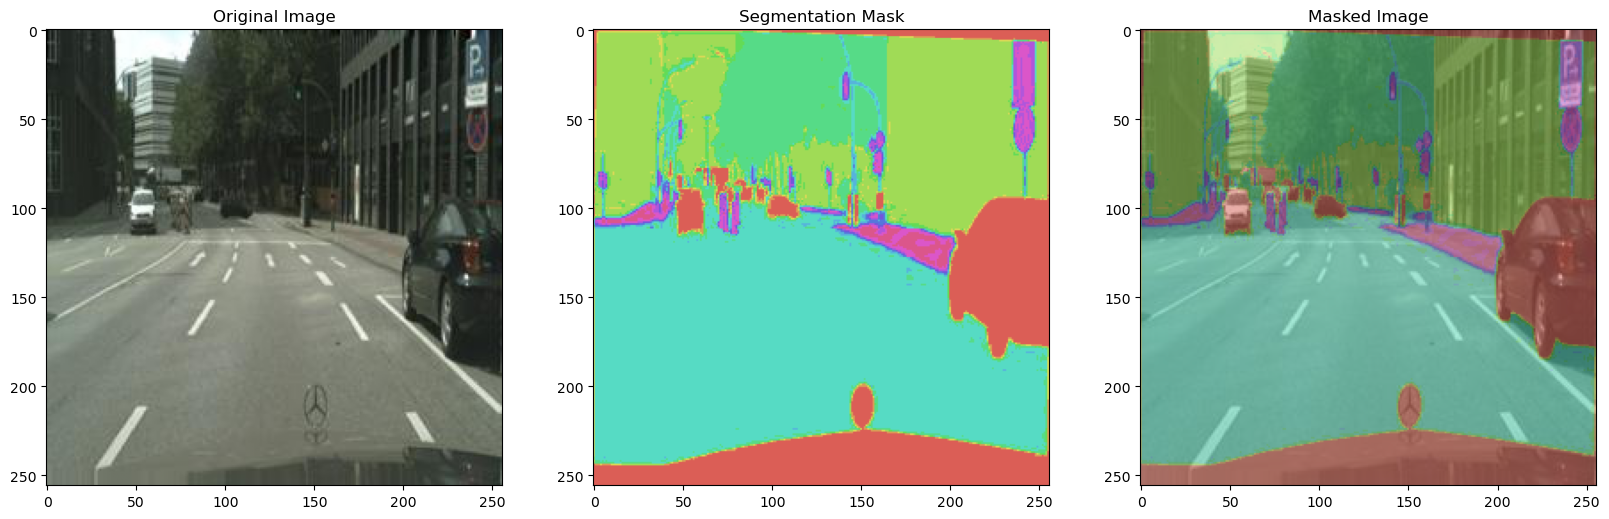

In [9]:
image = imgs[0]
mask = give_color_to_seg_img(segs[0])
masked_image = image * 0.5 + mask * 0.5

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

In [10]:
smooth = 1

def dice_coef(y_true, y_pred):
    And = tf.reduce_sum(y_true * y_pred)
    return (2 * And + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

In [11]:
model = SegFormer_B0(input_shape = (256, 256, 3), num_classes = 13)

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [13]:
TRAIN_STEPS = len(train_gen)
VAL_STEPS = len(val_gen)

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS, 
          validation_steps=VAL_STEPS, epochs=50, callbacks = [checkpoint])

Epoch 1/50


2023-04-26 14:28:58.356686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/seg_former_head/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.6395
Epoch 1: val_loss improved from inf to 1.57448, saving model to seg_model.h5
92/92 [==============================] - 123s 804ms/step - loss: 1.2601 - accuracy: 0.6395 - val_loss: 1.5745 - val_accuracy: 0.4857
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 1.0273 - accuracy: 0.7057
Epoch 2: val_loss improved from 1.57448 to 1.23874, saving model to seg_model.h5
92/92 [==============================] - 53s 572ms/step - loss: 1.0273 - accuracy: 0.7057 - val_loss: 1.2387 - val_accuracy: 0.6708
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.7202
Epoch 3: val_loss improved from 1.23874 to 1.18652, saving model to seg_model.h5
92/92 [==============================] - 50s 547ms/step - loss: 0.9741 - accuracy: 0.7202 - val_loss: 1.1865 - val_accuracy: 0.6749
Epoch 4/50
92/92 [==============================] - ETA: 0s - loss: 0.9269 - accuracy: 0.7333

In [14]:
test_gen = DataGenerator(valid_filenames, 1)

1/1 [==============================] - 2s 2s/step


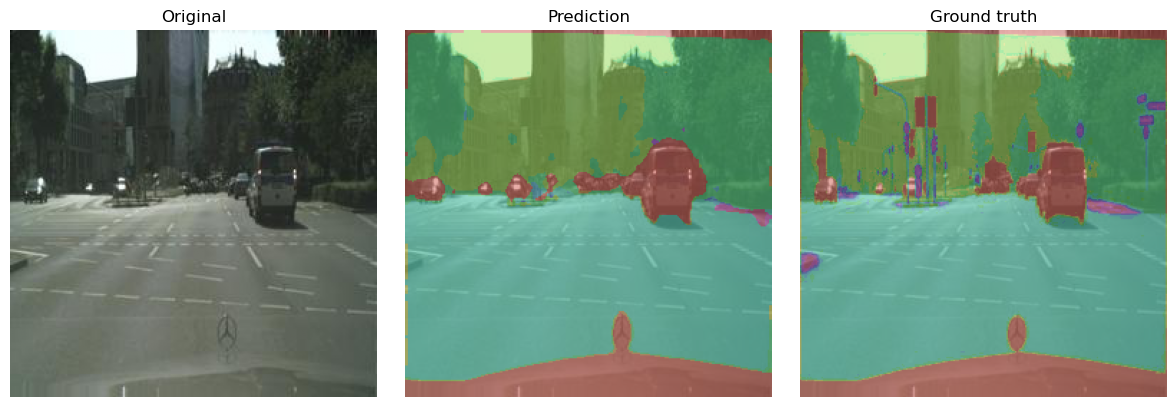

1/1 [==============================] - 0s 50ms/step


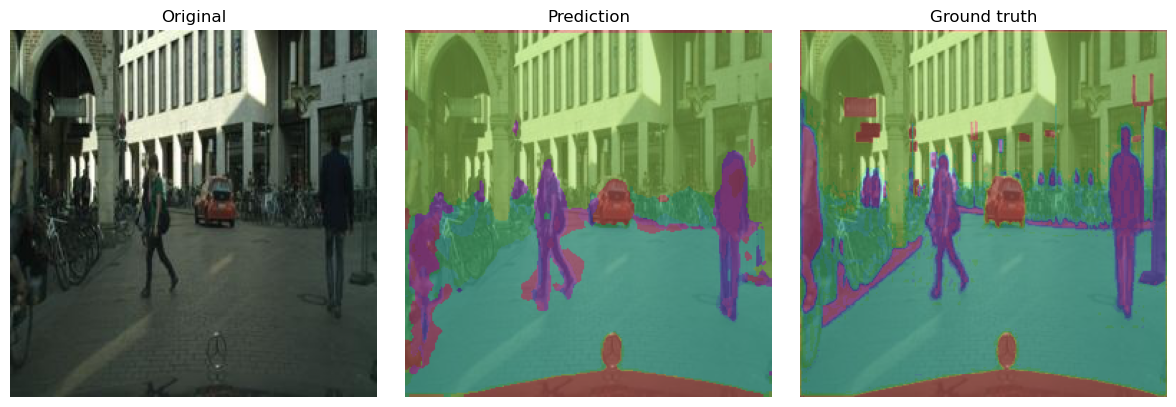

1/1 [==============================] - 0s 41ms/step


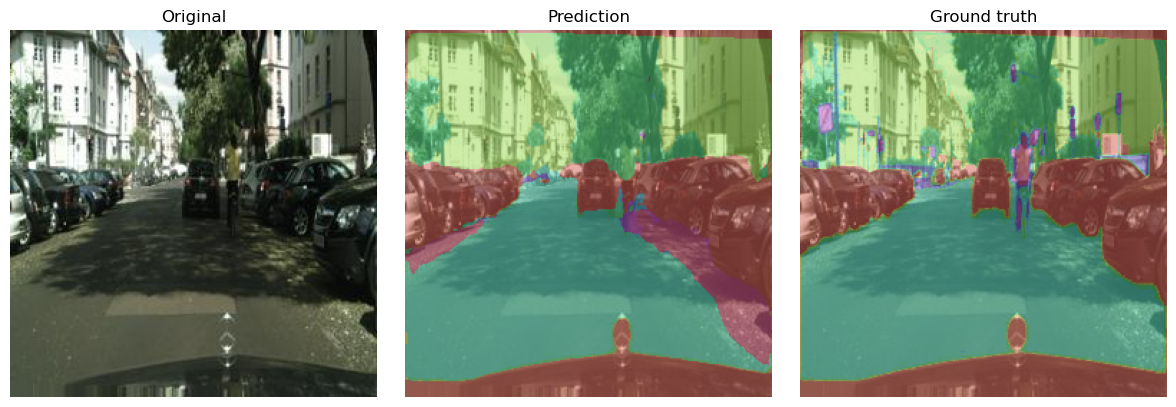

1/1 [==============================] - 0s 41ms/step


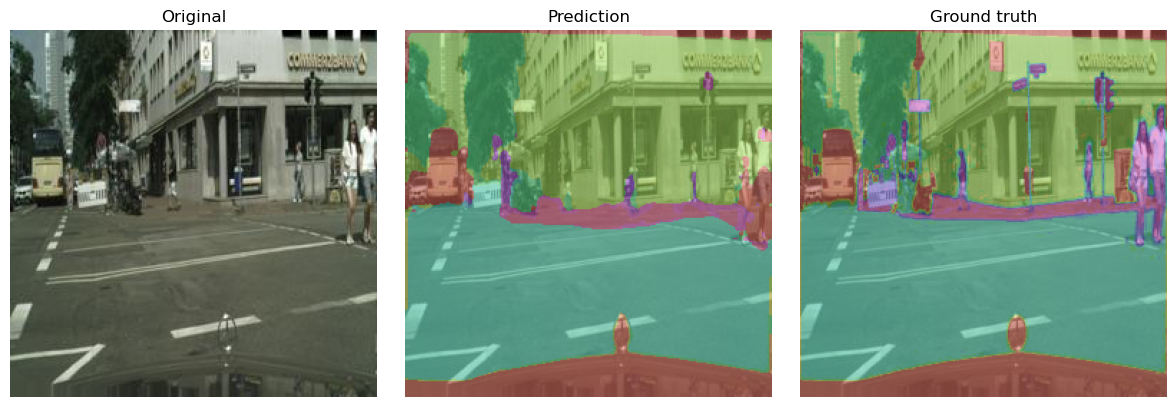

1/1 [==============================] - 0s 40ms/step


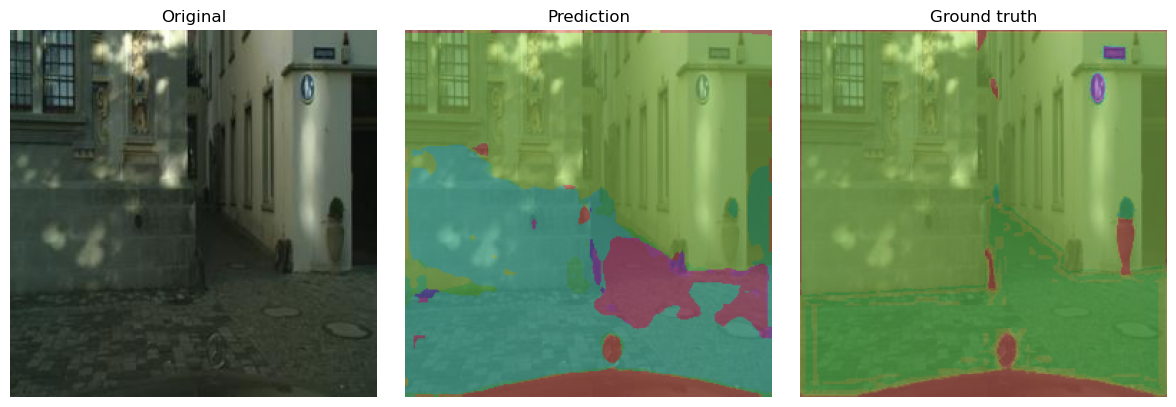

1/1 [==============================] - 0s 38ms/step


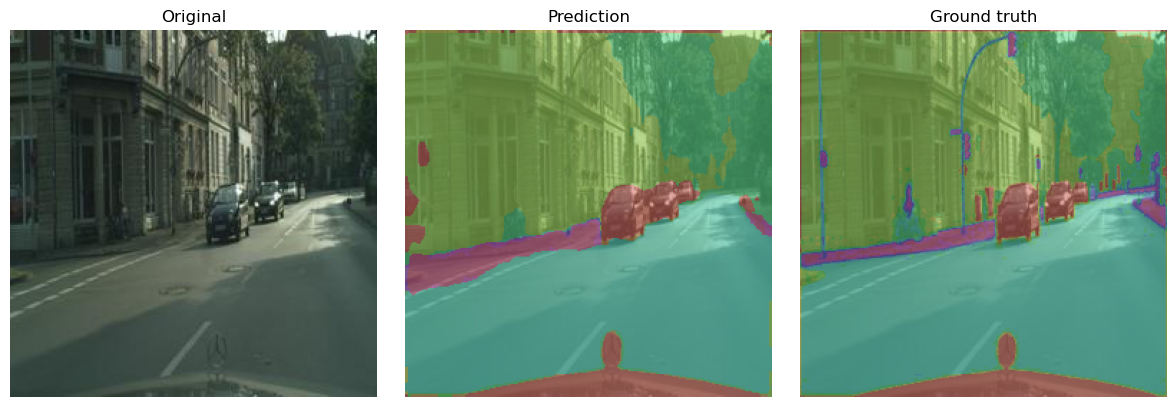

1/1 [==============================] - 0s 51ms/step


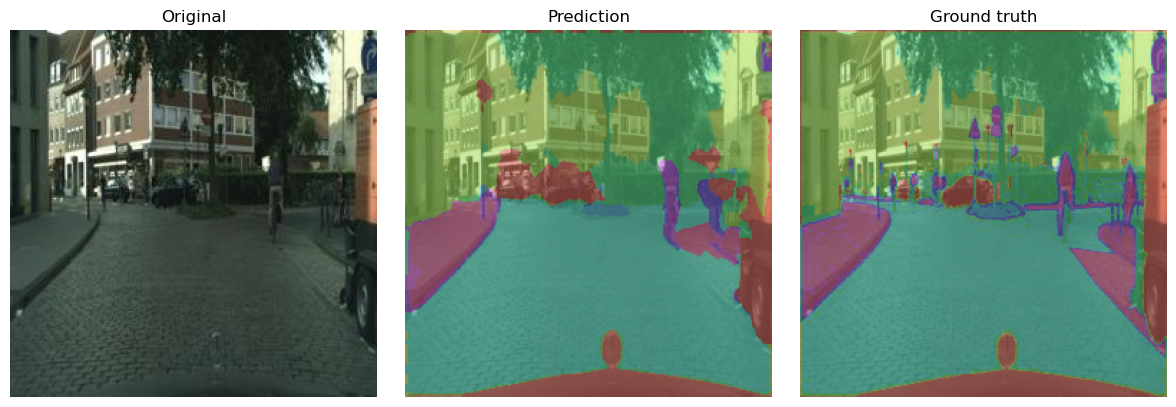

1/1 [==============================] - 0s 40ms/step


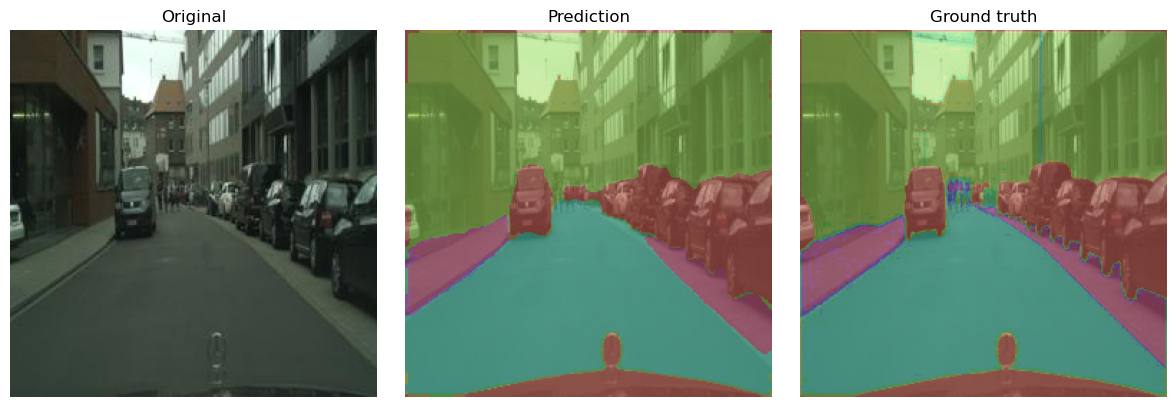

1/1 [==============================] - 0s 39ms/step


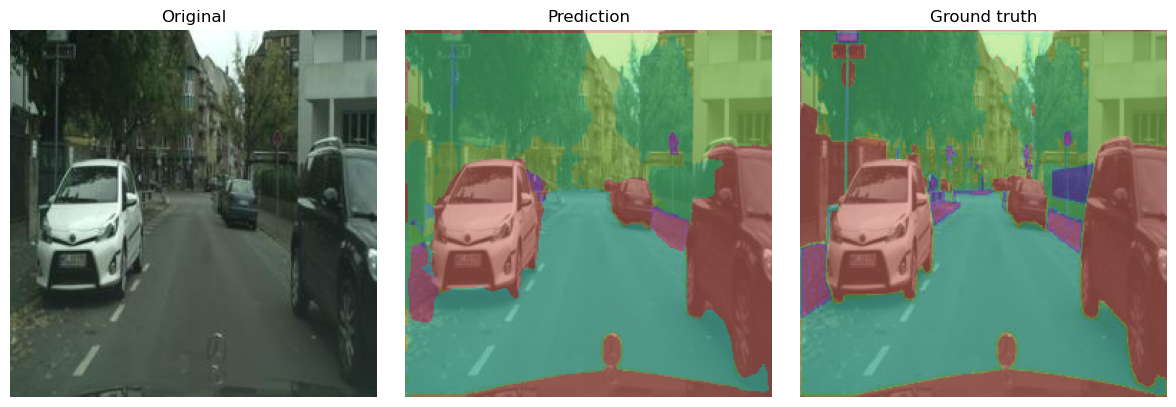

1/1 [==============================] - 0s 41ms/step


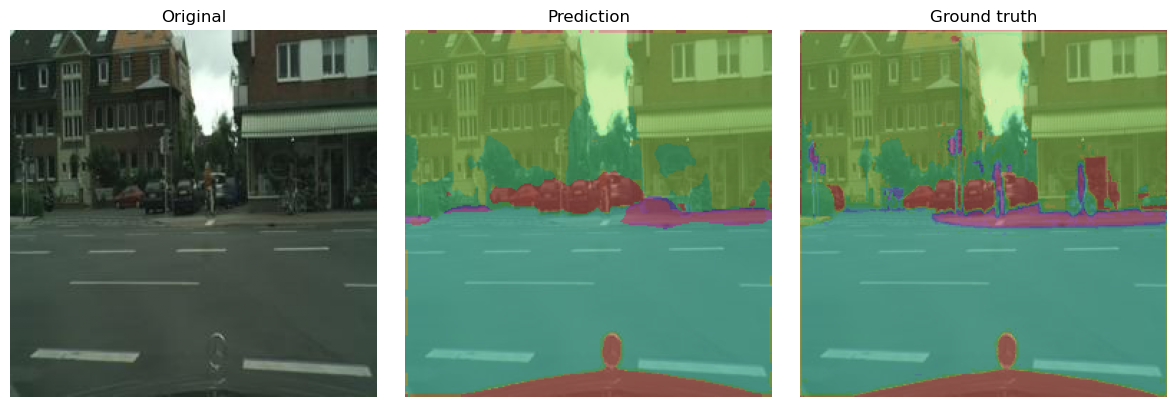

1/1 [==============================] - 0s 41ms/step


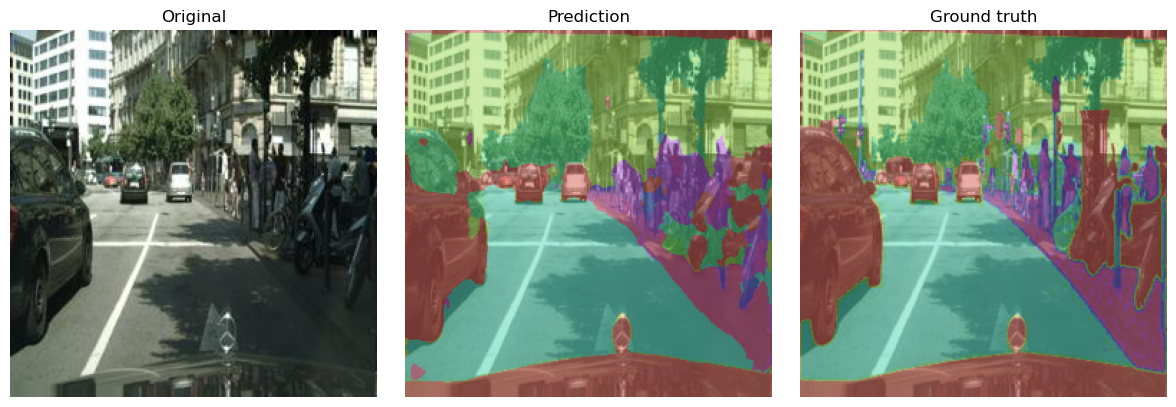

1/1 [==============================] - 0s 42ms/step


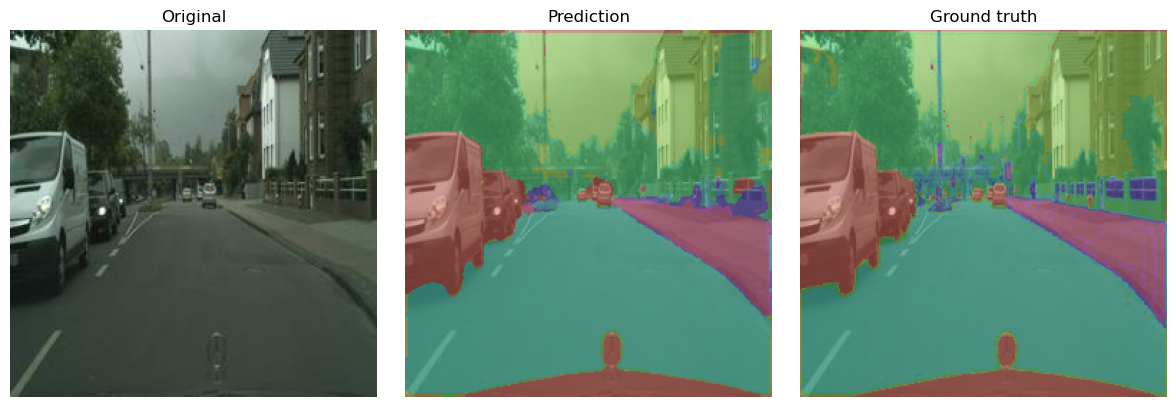

In [15]:
test_iter = iter(test_gen)
for i in range(12):
    imgs, segs = next(test_iter)
    pred = model.predict(imgs)
    _p = give_color_to_seg_img(np.argmax(pred[0], axis=-1))
    _s = give_color_to_seg_img(segs[0])

    predimg = cv2.addWeighted(imgs[0], 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[0], 0.5, _s, 0.5, 0)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Original")
    plt.imshow(imgs[0])
    plt.axis("off")
    
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(133)
    plt.title("Ground truth")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()